# 02. Feature Engineering & Baseline Model

**Project:** Swiss Rental Price Prediction<br>
**Author:** Dimitrios Mylonas

**Objective:**
Enrich the cleaned dataset with domain-specific features (Geospatial & NLP) and establish a strong statistical baseline using Linear Regression.

**Methodology:**
1.  **Geospatial Engineering:** Calculate distances to major Swiss economic hubs (Zurich, Geneva, Basel, Bern, Lausanne).
2.  **NLP Feature Extraction:** Extract high-value keywords (e.g., "Lake View", "Penthouse") from the description text.
3.  **Data Splitting:** strict Train/Test split to prevent data leakage.
4.  **Encoding & Scaling:** Apply One-Hot Encoding for Cantons and Target Encoding for Zip codes.
5.  **Baseline Modeling:** Train a Ridge Regression model and evaluate using MAE (Mean Absolute Error).

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce  # You might need to pip install category_encoders

# Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style("whitegrid")

# Load Cleaned Data
df = pd.read_pickle('../data/processed/01_cleaned_data.pkl')
print(f"Data loaded: {df.shape}")

Data loaded: (16005, 26)


## 1. Feature Engineering

### 1.1 Geospatial Features (Distance to Hubs)
In Switzerland, rent is heavily correlated with proximity to major employment centers. We calculate the Haversine distance (as the crow flies) to the "Big 5" cities.

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the great circle distance between two points 
    on the earth (specified in decimal degrees) in km.
    """
    R = 6371  # Radius of earth in km
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Coordinates of major Swiss hubs
hubs = {
    'Zurich_HB': (47.378177, 8.540192),
    'Geneva_Cornavin': (46.210226, 6.142456),
    'Basel_SBB': (47.547412, 7.589556),
    'Bern_HB': (46.948833, 7.439122),
    'Lausanne_Gare': (46.516777, 6.629095)
}

# Apply calculation
for city, (lat_c, lon_c) in hubs.items():
    df[f'dist_to_{city}'] = haversine_distance(df['Lat'], df['Lon'], lat_c, lon_c)

# Create a 'min_dist_to_hub' feature (Distance to the closest major city)
df['dist_to_closest_hub'] = df[[f'dist_to_{city}' for city in hubs]].min(axis=1)

print("Geospatial features created.")
df[['City', 'dist_to_Zurich_HB', 'dist_to_Geneva_Cornavin']].head()

Geospatial features created.


,City,dist_to_Zurich_HB,dist_to_Geneva_Cornavin
0,Zürich,4.389708,221.750574
1,Rüti,26.995945,237.184611
2,Zürich,4.460629,227.971210
3,Männedorf,17.488008,226.551360
4,Zürich,4.290206,221.487168


### 1.2 NLP Feature Extraction (Description Analysis)
The `Description` field often contains details that structured columns miss. We extract boolean flags for high-value keywords.
*   *Note:* We look for German, French, and English keywords common in Swiss listings.

In [3]:
# Keywords for "Luxury/Special" features
keywords = {
    'has_lake_view': ['see', 'lac', 'lake', 'sicht', 'vue', 'view'],
    'is_attic': ['attika', 'attique', 'penthouse', 'dachwohnung'],
    'is_quiet': ['ruhig', 'calme', 'quiet'],
    'is_sunny': ['sonnig', 'ensoleillé', 'sunny']
}

def check_keywords(text, words):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    for w in words:
        if w in text:
            return 1
    return 0

for feature_name, word_list in keywords.items():
    df[feature_name] = df['Description'].apply(lambda x: check_keywords(x, word_list))

print("NLP features created.")
display(df[list(keywords.keys())].sum())

NLP features created.


has_lake_view    7757
is_attic          862
is_quiet         4823
is_sunny         1980
dtype: int64

### 1.3 External Data Augmentation: Municipal Tax Burdens
We integrate real 2025 tax data at the municipality level.
*   **Source:** Federal Tax Administration / Cantonal Data.
*   **Logic:** We sum `income_tax_canton` and `income_tax_commune` to get the total tax multiplier.
*   **Merge Strategy:** We merge on `City` name. Since names might have slight spelling variations (e.g., "St. Gallen" vs "Sankt Gallen"), we implement a fallback strategy using the Canton's median tax rate for non-matching cities.

In [4]:
# --- 1.3 External Data Augmentation: Municipal Tax Burdens (Refined) ---

# 1. Load external tax data
tax_df = pd.read_csv('../data/external/tax_data_2025.csv')
tax_df['tax_rate'] = tax_df['income_tax_canton'] + tax_df['income_tax_commune']

# 2. Text Cleaning Function
def clean_names(name):
    if not isinstance(name, str): return ''
    name = name.lower().strip()
    name = name.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe')
    name = name.replace('è', 'e').replace('é', 'e').replace('à', 'a')
    name = name.replace('â', 'a').replace('ç', 'c')
    name = name.replace('st.', 'st').replace('sankt', 'st')
    # Remove text inside parentheses (e.g., "Renens (VD)" -> "renens")
    name = name.split('(')[0].strip() 
    return name

# 3. Prepare Tax Data Keys
tax_df['clean_commune'] = tax_df['commune'].apply(clean_names)
tax_df['join_key'] = tax_df['clean_commune'] + '_' + tax_df['canton'].str.lower()
tax_map = dict(zip(tax_df['join_key'], tax_df['tax_rate']))


sys.path.append(os.path.abspath('../src'))

from mappings import CITY_TO_COMMUNE_MAP

# 4. Use the imported map
sys.path.append(os.path.abspath('../src'))
from mappings import CITY_TO_COMMUNE_MAP
manual_map = CITY_TO_COMMUNE_MAP 

# 5. Fallback Dictionary
canton_fallback = tax_df.groupby('canton')['tax_rate'].median().to_dict()

# 6. Smart Lookup Function with Source Tracking
def get_tax_rate_smart(row):
    city_raw = str(row['City'])
    city_clean = clean_names(city_raw)
    canton_clean = row['Canton'].lower()
    
    # A. Check Manual Map
    if city_clean in manual_map:
        city_clean = clean_names(manual_map[city_clean])
    elif city_raw.lower() in manual_map:
        city_clean = clean_names(manual_map[city_raw.lower()])

    # B. Construct Key
    key = f"{city_clean}_{canton_clean}"
    
    if key in tax_map:
        return tax_map[key], "Exact Match"
    
    # C. Fallback
    if row['Canton'] in canton_fallback:
        return canton_fallback[row['Canton']], "Canton Median"
        
    return 200.0, "Global Median"

# 7. Apply and Split Tuple
# We perform the apply once and split the results into two columns
temp_result = df.apply(get_tax_rate_smart, axis=1)
df['tax_rate'] = [x[0] for x in temp_result]
df['tax_source'] = [x[1] for x in temp_result]

# 8. True Validation
print("Match Quality Report:")
print(df['tax_source'].value_counts())

print("\nSample Mismatches (Using Canton Median):")
print(df[df['tax_source'] == 'Canton Median']['City'].value_counts().head(20))

Match Quality Report:
tax_source
Exact Match      15343
Canton Median      662
Name: count, dtype: int64

Sample Mismatches (Using Canton Median):
City
Sementina            6
Anzère               6
Bramois              6
Argnou (Ayent)       6
Ebmatingen           5
Cresciano            5
Cormérod             5
Cormagens            5
Pfaffhausen          5
St-Blaise            5
Werdenberg           5
Torgon               4
La Roche FR          4
Misery               4
St-Léonard           4
Charmey (Gruyère)    4
Zuben                4
Siviez (Nendaz)      4
Ravoire              4
Venthône             4
Name: count, dtype: int64


## 2. Data Splitting
**Crucial Step:** We split the data *before* any Target Encoding or Scaling. This prevents "Data Leakage" (information from the test set leaking into the training process), which is a common mistake in junior portfolios.

In [5]:
# Drop columns not needed for modeling
drop_cols = ['ID', 'Description', 'City', 'Date_Created', 'Link', 'Title'] # Keep Zip/Canton for encoding
model_df = df.drop(columns=[c for c in drop_cols if c in df.columns])

X = model_df.drop(columns=['Rent'])
y = model_df['Rent']

# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Train Shape: (12804, 34)
Test Shape: (3201, 34)


## 3. Preprocessing Pipeline
We build a Scikit-Learn pipeline to handle different data types:
*   **Numerical:** Scale using `StandardScaler` (Linear models require this).
*   **Categorical (Low Cardinality):** `OneHotEncoder` for `Canton`, `SubType`.
*   **Categorical (High Cardinality):** `TargetEncoder` for `Zip`.
    *   *Why Target Encode Zip?* There are 3000+ Zip codes. One-Hot encoding would create a massive, sparse matrix. Target Encoding replaces the Zip code with the *average rent* of that Zip code (computed only on Training data).

In [6]:
# Define column groups
num_features = [
    'Rooms', 'Area_m2', 'Floor', 'Lat', 'Lon',
    'dist_to_Zurich_HB', 'dist_to_Geneva_Cornavin', 'dist_to_Basel_SBB', 
    'dist_to_Bern_HB', 'dist_to_Lausanne_Gare', 'dist_to_closest_hub',
    'tax_rate'
]
binary_features = [
    'is_rent_estimated', 'year_built_is_missing', 'is_renovated',
    'Balcony', 'Elevator', 'Parking', 'View', 'Fireplace', 
    'Child_Friendly', 'CableTV', 'New_Building', 'Minergie', 'Wheelchair',
    'has_lake_view', 'is_attic', 'is_quiet', 'is_sunny'
]
cat_features_onehot = ['Canton', 'SubType']
cat_features_target = ['Zip']

# Create Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_transformer = ce.TargetEncoder(cols=['Zip'])

# Combine into Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat_onehot', categorical_transformer, cat_features_onehot),
        ('cat_target', target_transformer, cat_features_target),
        ('bin', 'passthrough', binary_features) # Don't scale binary flags
    ]
)

# Display the plan
print("Preprocessing pipeline constructed.")

Preprocessing pipeline constructed.


## 4. Baseline Model (Ridge Regression)
We use Ridge Regression (Linear Regression with L2 Regularization).
*   **Why Ridge?** It handles multicollinearity better than simple OLS (e.g., `dist_to_Zurich` and `dist_to_closest_hub` are correlated).
*   **Metric:** We focus on **MAE (Mean Absolute Error)** because it represents the average error in Swiss Francs (CHF), which is easy to explain to stakeholders.

In [7]:
# Create Pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Train
print("Training Baseline Model...")
baseline_pipeline.fit(X_train, y_train)

# Predict
y_pred_train = baseline_pipeline.predict(X_train)
y_pred_test = baseline_pipeline.predict(X_test)

# Evaluate
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("-" * 30)
print(f"Baseline Performance:")
print(f"MAE Train: {mae_train:.2f} CHF")
print(f"MAE Test:  {mae_test:.2f} CHF  <-- Key Metric")
print(f"RMSE Test: {rmse_test:.2f} CHF")
print(f"R2 Score:  {r2_test:.4f}")
print("-" * 30)

Training Baseline Model...
------------------------------
Baseline Performance:
MAE Train: 608.10 CHF
MAE Test:  641.30 CHF  <-- Key Metric
RMSE Test: 1048.43 CHF
R2 Score:  0.5788
------------------------------


## 5. Error Analysis
Understanding *where* the baseline fails helps us improve the next model.

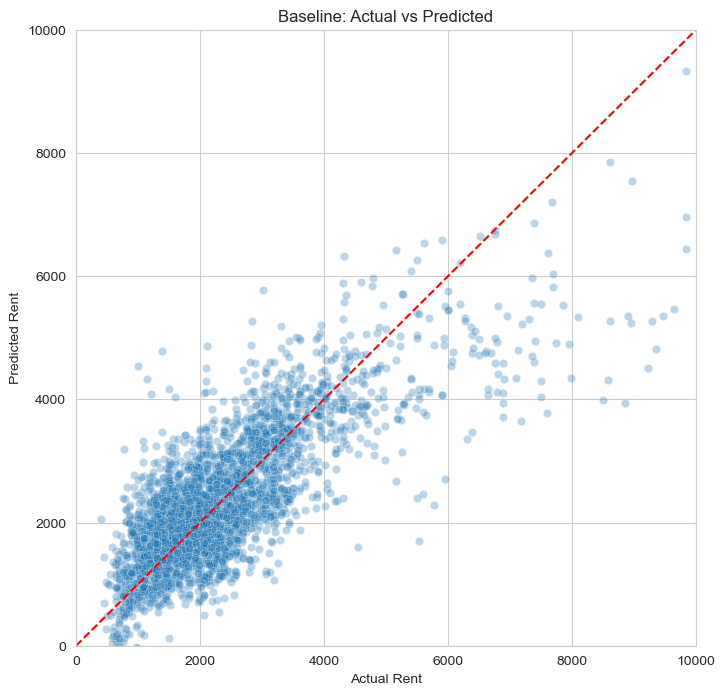

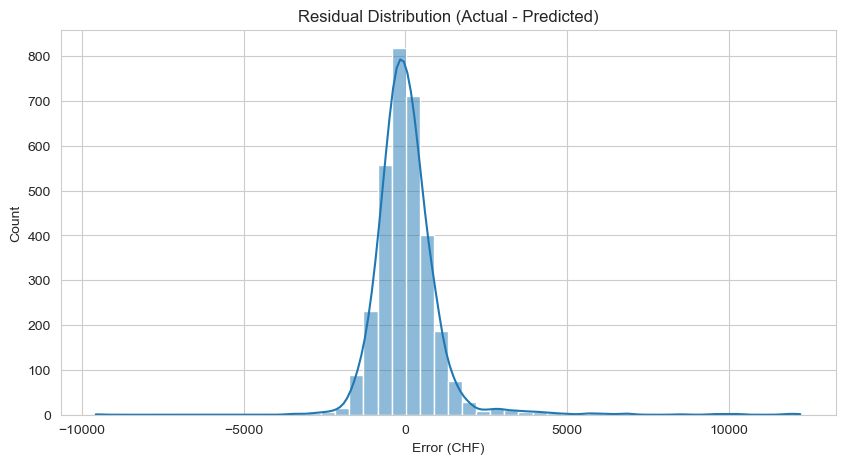

In [8]:
# 1. Predicted vs Actual
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([0, 10000], [0, 10000], 'r--') # Perfect prediction line
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Baseline: Actual vs Predicted')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.show()

# 2. Residual Distribution
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residual Distribution (Actual - Predicted)')
plt.xlabel('Error (CHF)')
plt.show()

## 6. Export for Machine Learning
We save the split datasets. We do **not** save the processed arrays yet, because in Notebook 03 (XGBoost), we might want to handle categorical variables differently (XGBoost can handle them natively). However, we save the feature-engineered DataFrame.

In [9]:
# Save the feature-engineered data (before split) for NB 03
# We will redo the split in NB 03 to ensure consistency, 
# but we need the columns we created (distances, NLP flags)
model_df['Rent'] = y # Add target back

model_df.to_pickle('../data/processed/02_featured_data.pkl')
print("Feature-engineered dataset saved.")

Feature-engineered dataset saved.
